# Introduction to Graph Neural Nets with JAX/jraph

*Lisa Wang, DeepMind (wanglisa@deepmind.com), Nikola Jovanović, ETH Zurich (nikola.jovanovic@inf.ethz.ch)*

**Colab Runtime:**

If possible, please use a GPU hardware accelerator to run this colab. You can choose that under *Runtime > Change Runtime Type*.

**Prerequisites:**
* Some familiarity with [JAX](https://github.com/google/jax), you can refer to this [colab](https://colab.sandbox.google.com/github/google/jax/blob/master/docs/jax-101/01-jax-basics.ipynb) for an introduction to JAX.
* Neural network basics
* Graph theory basics (MIT Open Courseware [slides](https://ocw.mit.edu/courses/civil-and-environmental-engineering/1-022-introduction-to-network-models-fall-2018/lecture-notes/MIT1_022F18_lec2.pdf) by Amir Ajorlou)


We recommend watching the [Theoretical Foundations of Graph Neural Networks Lecture](https://www.youtube.com/watch?v=uF53xsT7mjc&) by Petar Veličković before working through this colab. The talk provides a theoretical introduction to Graph Neural Networks (GNNs), historical context and motivating examples.


**Outline:**
* [Fundamental Graph Concepts](#scrollTo=gsKA-syx_LUi)
* [Graph Prediction Tasks](#scrollTo=spQGRxhPN8Eo)
* [Intro to the jraph Library](#scrollTo=3C5YI9M0vwvb)
* [Graph Convolutional Network (GCN) Layer](#scrollTo=NZRMF2d-h2pd)
* [Build GCN Model with Multiple Layers](#scrollTo=lha8rbQ78l3S)
* [Node Classification with GCN on Karate Club Dataset](#scrollTo=Z5t7kw7SE_h4)
* [Graph Attention (GAT) Layer](#scrollTo=yg8g96NdBCK6)
* [Train GAT Model on Karate Club Dataset](#scrollTo=anfVGJwBe27v)
* [Graph Classification on MUTAG (Molecules)](#scrollTo=n5TxaTGzBkBa)
* [Link Prediction on CORA (Citation Network)](#scrollTo=OwVE88dTRC6V)
* [Bonus: Intro to Graph Adversarial Attacks](#scrollTo=35kbP8GZRFEm)


**Additional Resources:**

* Battaglia et al. (2018): [Relational inductive biases, deep learning, and graph networks](https://arxiv.org/pdf/1806.01261)

---

Some sections in this colab build on the [GraphNets Tutorial colab in pytorch](https://github.com/eemlcommunity/PracticalSessions2021/blob/main/graphnets/graphnets_tutorial.ipynb) by Nikola Jovanović.

We would like to thank Razvan Pascanu and Petar Veličković for their valuable input and feedback.

---
*Copyright 2022 by the Authors.*

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0*

*Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.*

## Setup: Install and Import libraries

In [1]:
!pip install -q dm-haiku flax git+https://github.com/deepmind/jraph.git

     |████████████████████████████████| 309 kB 5.5 MB/s 
     |████████████████████████████████| 197 kB 14.2 MB/s 
     |████████████████████████████████| 217 kB 38.5 MB/s 
     |████████████████████████████████| 140 kB 21.5 MB/s 
     |████████████████████████████████| 596 kB 37.4 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 72 kB 249 kB/s 


In [108]:
import functools
import math
import pickle
import random
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from warnings import filterwarnings

import flax
import haiku as hk
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import optax
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

%matplotlib inline

In [109]:
filterwarnings('ignore')

In [110]:
random.seed(42)
np.random.seed(42)

In [111]:
plt.rcParams['figure.figsize'] = (18, 10)

## Fundamental Graph Concepts
A graph consists of a set of nodes and a set of edges, where edges form connections between nodes.

More formally, a graph is defined as $ \mathcal{G} = (\mathcal{V}, \mathcal{E})$ where $\mathcal{V}$ is the set of vertices / nodes, and $\mathcal{E}$ is the set of edges.

In an **undirected** graph, each edge is an unordered pair of two nodes $ \in \mathcal{V}$. E.g. a friend network can be represented as an undirected graph, assuming that the relationship "*A is friends with B*" implies "*B is friends with A*".

In a **directed** graph, each edge is an ordered pair of nodes $ \in \mathcal{V}$. E.g. a citation network would be best represented with a directed graph, since the relationship "*A cites B*" does not imply "*B cites A*".

The **degree** of a node is defined as the number of edges incident on it, i.e. the sum of incoming and outgoing edges for that node.

The **in-degree** is the sum of incoming edges only, and the **out-degree** is the sum of outgoing edges only.

There are several ways to represent $\mathcal{E}$:
1. As a **list of edges**: a list of pairs $(u,v)$, where $(u,v)$ means that there is an edge going from node $u$ to node $v$.
2. As an **adjacency matrix**: a binary square matrix $A$ of size $|\mathcal{V}| \times |\mathcal{V}|$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
3. As an **adjacency list**: An array of $|\mathcal{V}|$ unordered lists, where the $i$th list corresponds to the $i$th node, and contains all the nodes directly connected to node $i$.


Example: Below is a directed graph with four nodes and five edges.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/toy_graph.png" width="700px">

The arrows on the edges indicate the direction of each edge, e.g. there is an edge going from node 0 to node 1. Between node 0 and node 3, there are two edges: one going from node 0 to node 3 and one from node 3 to node 0.

Node 0 has out-degree of 2, since it has two outgoing edges, and an in-degree of 2, since it has two incoming edges.

The list of edges is:
$$[(0, 1), (0, 3), (1, 2), (2, 0), (3, 0)]$$

As adjacency matrix:

$$\begin{array}{l|llll}
 source \setminus dest    & n_0 & n_1 & n_2 & n_3 \\ \hline
n_0 & 0    & 1    & 0    & 1    \\
n_1 & 0    & 0    & 1    & 0    \\
n_2 & 1    & 0    & 0    & 0    \\
n_3 & 1    & 0    & 0    & 0
\end{array}$$

As adjacency list:

$$[\{1, 3\}, \{2\}, \{0\}, \{0\}]$$



## Graph Prediction Tasks
What are the kinds of problems we want to solve on graphs?


The tasks fall into roughly three categories:

1. **Node Classification**: E.g. what is the topic of a paper given a citation network of papers?
2. **Link Prediction / Edge Classification**: E.g. are two people in a social network friends?
3. **Graph Classification**: E.g. is this protein molecule (represented as a graph) likely going to be effective?

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

*The three main graph learning tasks. Image source: Petar Veličković.*

Which examples of graph prediction tasks come to your mind? Which task types do they correspond to?

We will create and train models on all three task types in this tutorial.


## Intro to the jraph Library

In the following sections, we will learn how to represent graphs and build GNNs in Python. We will use
[jraph](https://github.com/deepmind/jraph), a lightweight library for working with GNNs in [JAX](https://github.com/google/jax).
### Representing a graph in jraph

In jraph, a graph is represented with a `GraphsTuple` object. In addition to defining the graph structure of nodes and edges, you can also store node features, edge features and global graph features in a `GraphsTuple`.

In the `GraphsTuple`, edges are represented in two aligned arrays of node indices: senders (source nodes) and receivers (destinaton nodes).
Each index corresponds to one edge, e.g. edge `i` goes from `senders[i]` to `receivers[i]`.

You can even store multiple graphs in one `GraphsTuple` object.

We will start with creating a simple directed graph with 4 nodes and 5 edges. We will also add toy features to the nodes, using `2 * node_index` as the feature.

We will later use this toy graph in the GCN demo.



In [5]:
def build_toy_graph() -> jraph.GraphsTuple:
    '''Define a four node graph, each node has a scalar as its feature.

    Nodes are defined implicitly by their features.
    We will create a jnp.array of four nodes, each with a feature,
    e.g. node 0 has feature [0.], node 1 has featre [2.] etc.

    We will specify 5 directed edges connecting the nodes.
    We define edges with two jnp.arrays: `senders` source node indices)
    and `receivers` (destination node indices).
    For example, to add an edge from node 0 to node 1, we append 0 to senders,
    and 1 to receivers.

    Edge attributes are stored in the `edges` jnp.array.

    The number of nodes (4) and the number of edges (5) are stored
    in single-value single-dimension jnp.arrays.

    The graph label (in this case, 1) is stored in a 2-dimensional jnp.array.

    Returns:
        A jraph.GraphsTuple.
    '''
    return jraph.GraphsTuple(
        nodes=jnp.array([[0.], [2.], [4.], [6.]]),
        edges=jnp.array([[5.], [6.], [7.], [8.], [8.]]),
        senders=jnp.array([0, 1, 2, 3, 0]),
        receivers=jnp.array([1, 2, 0, 0, 3]),
        n_node=jnp.array([4]),
        n_edge=jnp.array([5]),
        globals=jnp.array([[1]])
        )

In [7]:
graph = build_toy_graph()

#### Inspecting the GraphsTuple


In [8]:
# Number of nodes
# Note that `n_node` returns an array. The length of `n_node` corresponds to
# the number of graphs stored in one `GraphsTuple`.
# In this case, we only have one graph, so n_node has length 1.
graph.n_node

DeviceArray([4], dtype=int32)

In [9]:
# Number of edges
graph.n_edge

DeviceArray([5], dtype=int32)

In [10]:
# Node features
graph.nodes

DeviceArray([[0.],
             [2.],
             [4.],
             [6.]], dtype=float32)

In [11]:
# Edge features
graph.edges

DeviceArray([[5.],
             [6.],
             [7.],
             [8.],
             [8.]], dtype=float32)

In [12]:
# Edges
graph.senders

DeviceArray([0, 1, 2, 3, 0], dtype=int32)

In [13]:
graph.receivers

DeviceArray([1, 2, 0, 0, 3], dtype=int32)

In [14]:
# Graph-level features
graph.globals

DeviceArray([[1]], dtype=int32)

#### Visualizing the Graph
To visualize the graph structure of the graph we created above, we will use the [`networkx`](networkx.org) library because it already has functions for drawing graphs.

We first convert the `jraph.GraphsTuple` to a `networkx.DiGraph`.

In [15]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
    '''Converts the jraph.GraphsTuple to a networkx.DiGraph.

    Args:
        jraph_graph: jraph.GraphsTuple

    Returns:
        A networkx.DiGraph.
    '''
    nodes, edges, receivers, senders, _, _, _ = jraph_graph
    nx_graph = nx.DiGraph()

    if nodes is None:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n)
    else:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n, node_feature=nodes[n])

    if edges is None:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]))
    else:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(
                int(senders[e]), int(receivers[e]), edge_feature=edges[e]
                )

    return nx_graph

In [16]:
def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
    '''
    Visualizes the structure of the jraph.GraphsTuple graph.

    Args:
        jraph_graph: jraph.GraphsTuple
    '''
    nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
    pos = nx.spring_layout(nx_graph)

    nx.draw(
        nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow'
        )

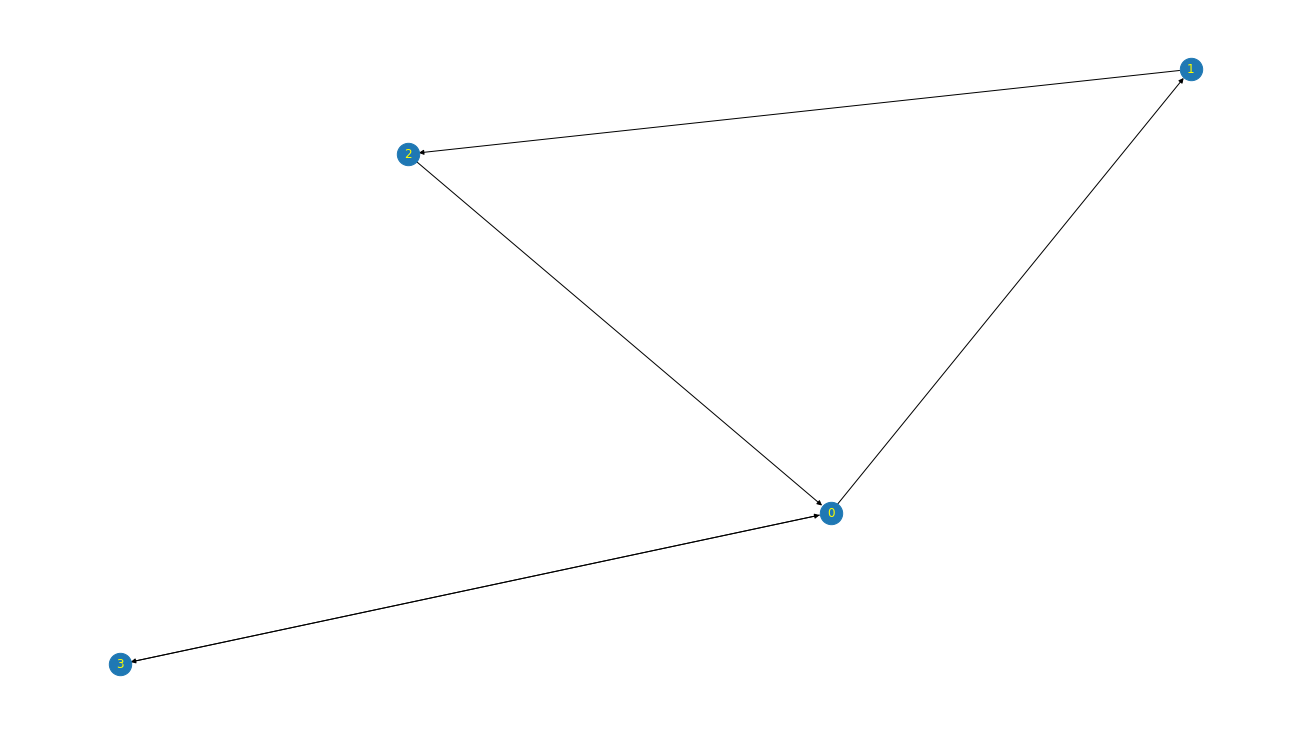

In [17]:
draw_jraph_graph_structure(graph)

## Graph Convolutional Network (GCN) Layer
Now let's implement our first graph network!

The graph convolutional network, introduced by by Kipf et al. (2017) in https://arxiv.org/abs/1609.02907, is one of the basic graph network architectures. We will build its core building block, the graph convolutional layer.

In a convolutional neural network (CNN), a convolutional filter (e.g. 3x3) is applied repeatedly to different parts of a larger input (e.g. 64x64) by striding across the input.

In a GCN, a convolution filter is applied to the neighbourhoods around a node in a graph.

However, there are also some differences to point out:
In contrast to the CNN filter, the neighbourhoods in a GCN can be of different sizes, and there is no ordering of inputs. To see that, note that the CNN filter performs a weighted sum aggregation over the inputs with learnable weights, where each filter input has its own weight. In the GCN, the same weight is applied to all neighbours and the aggregation function is not learned. In other words, in a GCN, each neighbor contributes equally. This is why the CNN filter is not order-invariant, but the GCN filter is.


<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_vs_gnn.png" width="700px">

Comparison of CNN and GCN filters.
Image source: https://arxiv.org/pdf/1901.00596.pdf

More specifically, the GCN layer performs two steps:

1. _Compute messages / update node features_: Create a feature vector $\vec{h}_n$ for each node $n$ (e.g. with an MLP). This is going to be the message that this node will pass to neighboring nodes.
2. _Message-passing / aggregate node features_: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages (features) from the nodes in its neighborhood. In a directed graph, only nodes from incoming edges are counted as neighbors. The image below shows this aggregation step. There are multiple options for aggregation in a GCN, e.g. taking the mean, the sum, the min or max. (Later in this tutorial, we will also see how we can make the aggregation function dependent on the node features by adding an attention mechanism in the Graph Attention Network.)

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="700px">

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"*<br>
Image source: [Petar Veličković](https://github.com/PetarV-/TikZ)


### Simple GCN Layer

In [18]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''
    A simple GCN layer. Unpacks GraphsTuple and performs two steps:

    1. Update node features;
    2. Aggregate node features over nodes in neighborhood.

    Computes new node features by aggregating messages from neighboring nodes.

    Args:
        graph: jraph.GraphsTuple

    Returns:
        An updated jraph.GraphsTuple.
    '''
    nodes, _, receivers, senders, _, _, _ = graph

    update_node_fn = lambda nodes: nodes
    nodes = update_node_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    aggregate_nodes_fn = jax.ops.segment_sum

    return graph._replace(nodes=tree.tree_map(
        lambda x: aggregate_nodes_fn(x[senders], receivers, total_num_nodes),
        nodes
        ))

We can now run the graph convolution on our toy graph from before.

In [19]:
graph = build_toy_graph()

Here is the visualized graph.

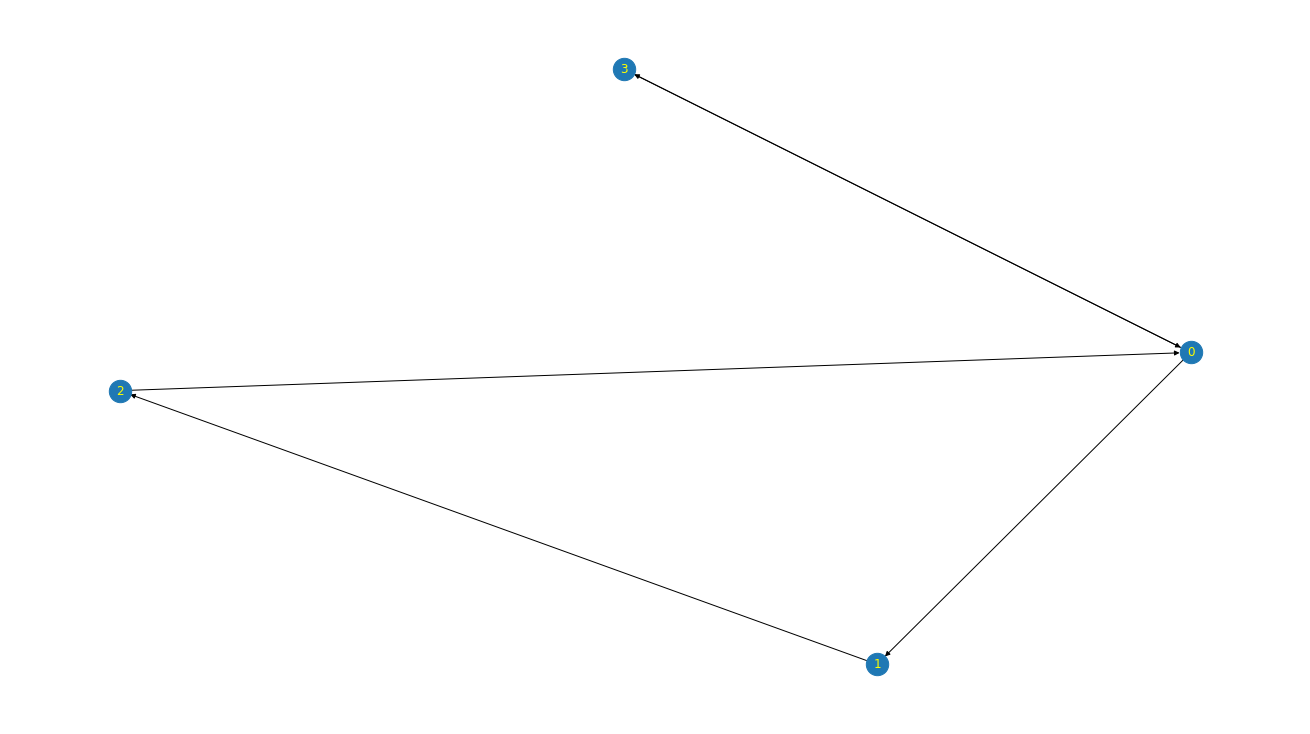

In [20]:
draw_jraph_graph_structure(graph)

In [21]:
out_graph = apply_simplified_gcn(graph)

Since we used the identity function for updating nodes and sum aggregation, we can verify the results pretty easily. As a reminder, in this toy graph, the node features are the same as the node index.

Node 0: sum of features from node 2 and node 3 $\rightarrow$ 10.

Node 1: sum of features from node 0 $\rightarrow$ 0.

Node 2: sum of features from node 1 $\rightarrow$ 2.

Node 3: sum of features from node 0 $\rightarrow$ 0.

In [22]:
out_graph.nodes

DeviceArray([[10.],
             [ 0.],
             [ 2.],
             [ 0.]], dtype=float32)

### Add Trainable Parameters to GCN layer
So far our graph convolution operation doesn't have any learnable parameters.
Let's add an MLP block to the update function to make it trainable.

In [23]:
class MLP(hk.Module):
    '''A Multi-layer perceptron (MLP).

    Attributes:
        features: a jnp.ndarray containing the MLP features
    '''
    def __init__(self, features: jnp.ndarray):
        '''Initializes a MLP with given features.'''
        super().__init__()
        self.features = features

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        '''Passes a given array x through the MLP and returns the results.'''
        layers = []

        for feat in self.features[:-1]:
            layers.append(hk.Linear(feat))
            layers.append(jax.nn.relu)
            layers.append(hk.Linear(self.features[-1]))

        mlp = hk.Sequential(layers)
        return mlp(x)

In [24]:
# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(features=[8, 4])(x)

#### Check outputs of `update_node_fn` with MLP Block

In [25]:
graph = build_toy_graph()

In [26]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

As output, we expect the updated node features. We should see one array of dim 4 for each of the 4 nodes, which is the result of applying a single MLP block to the features of each node individually.

In [27]:
out

DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
             [-0.14526577,  0.33038154, -0.50791115, -0.64371586],
             [-0.29053155,  0.6607631 , -1.0158223 , -1.2874317 ],
             [-0.43579727,  0.99114466, -1.5237335 , -1.9311478 ]],            dtype=float32)

#### Add Self-Edges (Edges connecting a node to itself)
For each node, add an edge of the node onto itself. This way, nodes will include themselves in the aggregation step.

In [28]:
def add_self_edges_fn(
    receivers: jnp.ndarray, senders: jnp.ndarray, total_num_nodes: int
        ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    '''Adds self-edges to the graph, sssuming self-edges are not in it yet.

    Args:
        receivers: a jnp.ndarray of source nodes
        senders: a jnp.ndarray of destination nodes
        total_num_nodes: a total number of nodes

    Returns:
        A tuple of two jnp.ndarrays – modified receivers and senders.
    '''
    receivers = jnp.concatenate(
        (receivers, jnp.arange(total_num_nodes)), axis=0
        )

    senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
    return receivers, senders

#### Add Symmetric Normalization

Note that the nodes may have different numbers of neighbors / degrees.
This could lead to instabilities during neural network training, e.g. exploding or vanishing gradients. To address that, normalization is a commonly used method. In this case, we will normalize by node degrees.

As a first attempt, we could count the number of incoming edges (including self-edge) and divide by that value.

More formally, let $A$ be the adjacency matrix defining the edges of the graph.

Then we define the degree matrix $D$ as a diagonal matrix with $D_{ii} = \sum_jA_{ij}$ (the degree of node $i$)


Now we can normalize $AH$ by dividing it by the node degrees:
$${D}^{-1}AH$$

To take both the in and out degrees into account, we can use symmetric normalization, which is also what Kipf and Welling proposed in their [paper](https://arxiv.org/abs/1609.02907):
$$D^{-\frac{1}{2}}AD^{-\frac{1}{2}}H$$





### General GCN Layer
Now we can write a more general and configurable version of the Graph Convolution layer, allowing the caller to specify:

*   **`update_node_fn`**: Function to use to update node features (e.g. the MLP block version we just implemented)
*   **`aggregate_nodes_fn`**: Aggregation function to use to aggregate messages from neighbourhood.
*  **`add_self_edges`**: Whether to add self edges for aggregation step.
* **`symmetric_normalization`**: Whether to add symmetric normalization.



In [29]:
class GraphConvolution():
    '''Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
    NOTE: This implementation does not add an activation after aggregation.
    If you are stacking layers, you may want to add an activation between
    each layer.
    '''
    def __init__(
        self,
        update_node_fn: Callable,
        aggregate_nodes_fn: Callable = jax.ops.segment_sum,
        add_self_edges: bool = False,
        symmetric_normalization: bool = True
            ):
        '''
        Inits a GCN layer.

        Args:
            update_node_fn: function used to update the nodes
            aggregate_nodes_fn: function used to aggregate the sender nodes
            add_self_edges: whether to add self-edges to nodes
            symmetric_normalization: whether to use symmetric normalization
        '''
        self.update_node_fn = update_node_fn
        self.aggregate_nodes_fn = aggregate_nodes_fn
        self.add_self_edges = add_self_edges
        self.symmetric_normalization = symmetric_normalization

    def __call__(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        '''Applies a Graph Convolution layer.

        First passes nodes through the node updater.

        If `self.add_self_edges` is True,
        then self-edges are added to the senders and receivers
        so that each node includes itself in aggregation.
        In principle, a `GraphsTuple` should partition by n_edge, but in
        this case it is not required since a GCN is agnostic to whether
        the `GraphsTuple` is a batch of graphs or a single large graph.

        If `self.symmetric_normalization` is True, then the graph is normalized:
        the normalization values are calculated,
        sender degrees are pre-normalized by sqrt,
        the pre-normalized nodes are aggregated,
        and receiver degrees are post-normalized by sqrt.

        Args:
            graph: a jraph.GraphsTuple

        Returns:
            Modified jraph.GraphsTuple.'''
        nodes, _, receivers, senders, _, _, _ = graph

        nodes = self.update_node_fn(nodes)
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]

        if self.add_self_edges:
            conv_receivers, conv_senders = add_self_edges_fn(
                receivers, senders, total_num_nodes
                )
        else:
            conv_senders = senders
            conv_receivers = receivers

        if self.symmetric_normalization:
            count_edges = lambda x: jax.ops.segment_sum(
                jnp.ones_like(conv_senders), x, total_num_nodes
                )
            sender_degree = count_edges(conv_senders)
            receiver_degree = count_edges(conv_receivers)

            nodes = tree.tree_map(lambda x: x * jax.lax.rsqrt(jnp.maximum(
                sender_degree, 1.0
                ))[:, None], nodes)

            nodes = tree.tree_map(lambda x: self.aggregate_nodes_fn(
                x[conv_senders], conv_receivers, total_num_nodes
                ), nodes)

            nodes = tree.tree_map(lambda x: (x * jax.lax.rsqrt(jnp.maximum(
                receiver_degree, 1.0
                ))[:, None]), nodes)
        else:
            nodes = tree.tree_map(lambda x: self.aggregate_nodes_fn(
                x[conv_senders], conv_receivers, total_num_nodes
                ), nodes)

        return graph._replace(nodes=nodes)

#### Test General GCN Layer

In [30]:
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(features=[8, 4])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

In [31]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-0.29652247,  0.6743885 , -1.0367693 , -1.3139795 ],
             [-0.07263289,  0.16519077, -0.25395554, -0.32185793],
             [-0.21789865,  0.4955723 , -0.7618666 , -0.9655737 ],
             [-0.21789864,  0.49557233, -0.76186675, -0.9655739 ]],            dtype=float32)

### Build GCN Model with Multiple Layers
With a single GCN layer, a node's representation after the GCN layer is only
influenced by its direct neighbourhood. However, we may want to consider larger neighbourhoods, i.e. more than just 1 hop away. To achieve that, we can stack
multiple GCN layers, similar to how stacking CNN layers expands the input region.

We will define a network with three GCN layers:

In [32]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''Defines a graph neural network with 3 GCN layers.

    Args:
        graph: jraph.GraphsTuple the network processes.

    Returns:
        Output graph with updated node values.
    '''
    layer_1 = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True
        )

    layer_2 = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
        add_self_edges=True
        )

    layer_3 = GraphConvolution(update_node_fn=hk.Linear(2))
    return layer_3(layer_2(layer_1(graph)))

In [33]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-0.32386127,  0.10707338],
             [-0.23884146,  0.07896456],
             [-0.19206828,  0.06350064],
             [-0.23884146,  0.07896456]], dtype=float32)

### Node Classification with GCN on Karate Club Dataset

Time to try out our GCN on our first graph prediction task!


#### Zachary's Karate Club Dataset

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a small dataset commonly used as an example for a social graph. It's great for demo purposes, as it's easy to visualize and quick to train a model on it.

A node represents a student or instructor in the club. An edge means that those two people have interacted outside of the class. There are two instructors in the club.

Each student is assigned to one of two instructors.

#### Optimizing the GCN on the Karate Club Node Classification Task

The task is to predict the assignment of students to instructors, given the social graph and only knowing the assignment of two nodes (the two instructors) a priori.

In other words, out of the 34 nodes, only two nodes are labeled, and we are trying to optimize the assignment of the other 32 nodes, by **maximizing the log-likelihood of the two known node assignments**.

We will compute the accuracy of our node assignments by comparing to the ground-truth assignments. **Note that the ground-truth for the 32 student nodes is not used in the loss function itself.**

Let's load the dataset:

In [34]:
def zacharys_karate_club() -> jraph.GraphsTuple:
    '''Returns GraphsTuple representing Zachary's karate club dataset.
    https://en.wikipedia.org/wiki/Zachary%27s_karate_club
    Zachary's karate club is used in literature as an example of a social graph.
    The task is to optimize the assignments of the students in the karate club
    to two distinct karate instructors (Mr. Hi and John A).

    Returns:
        A jraph.GraphsTuple representing the dataset.
        One-hot encoding is used for nodes, i.e. argmax(nodes) = node index.
        The graph contains no edge features.
    '''
    social_graph = [
                    (1, 0), (2, 0), (2, 1), (3, 0), (3, 1),
                    (3, 2), (4, 0), (5, 0), (6, 0), (6, 4),
                    (6, 5), (7, 0), (7, 1), (7, 2), (7, 3),
                    (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
                    (10, 5), (11, 0), (12, 0), (12, 3), (13, 0),
                    (13, 1), (13, 2), (13, 3), (16, 5), (16, 6),
                    (17, 0), (17, 1), (19, 0), (19, 1), (21, 0),
                    (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
                    (27, 24), (28, 2), (29, 23), (29, 26), (30, 1),
                    (30, 8), (31, 0), (31, 24), (31, 25), (31, 28),
                    (32, 2), (32, 8), (32, 14), (32, 15), (32, 18),
                    (32, 20), (32, 22), (32, 23), (32, 29), (32, 30),
                    (32, 31), (33, 8), (33, 9), (33, 13), (33, 14),
                    (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
                    (33, 23), (33, 26), (33, 27), (33, 28), (33, 29),
                    (33, 30),(33, 31), (33, 32)
                    ]

    social_graph += [(edge[1], edge[0]) for edge in social_graph]

    return jraph.GraphsTuple(
        n_node=jnp.asarray([34]),
        n_edge=jnp.asarray([len(social_graph)]),
        nodes=jnp.eye(34),
        edges=None,
        globals=None,
        senders=jnp.asarray([edge[0] for edge in social_graph]),
        receivers=jnp.asarray([edge[1] for edge in social_graph])
        )

In [35]:
def zacharys_karate_club_ground_truth() -> jnp.ndarray:
    '''Returns ground truth assignments for Zachary's karate club.

    Returns:
        A jnp.ndarray with ground truth assignments for Zachary's karate club.
    '''
    return jnp.array(
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        )

In [36]:
graph = zacharys_karate_club()

In [37]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


Visualize the karate club graph with circular node layout:

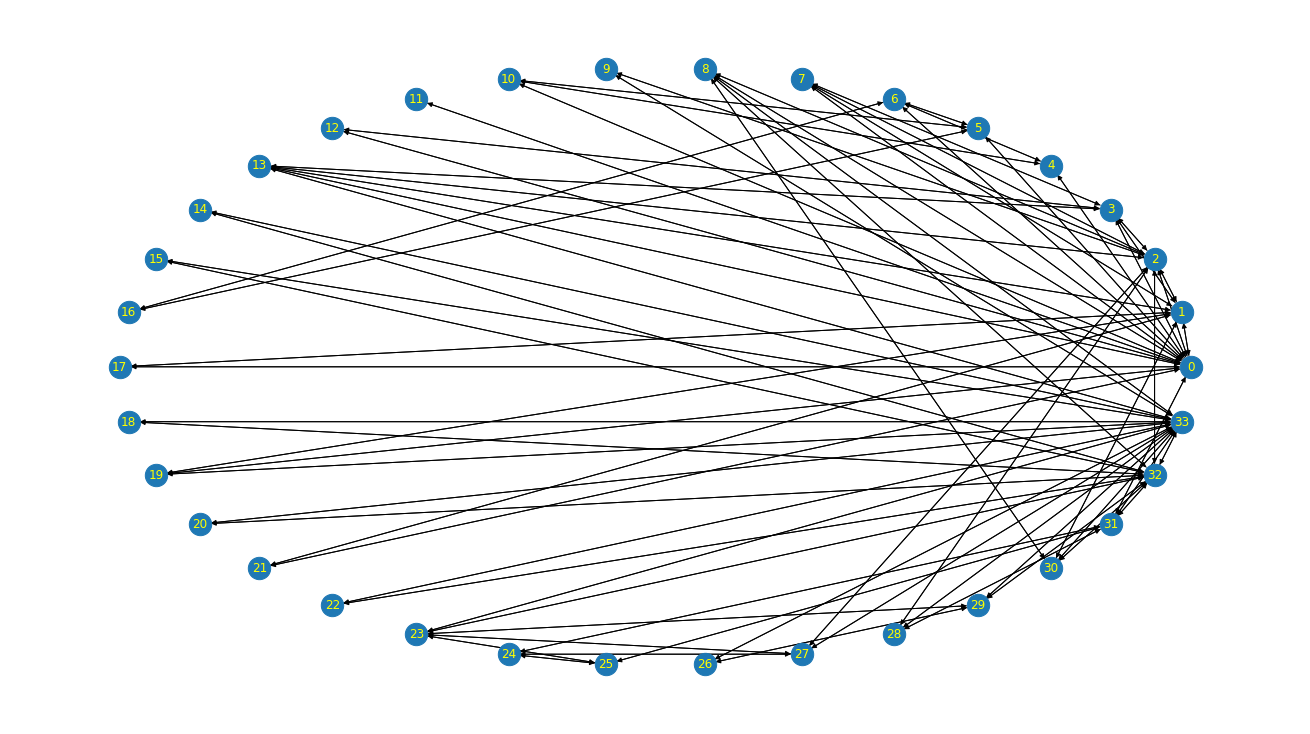

In [38]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

Define the GCN with the `GraphConvolution` layers we implemented:

In [39]:
def gcn_karate(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''A two-layer GCN for the karate club task.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        Output graph with updated node values.
    '''
    layer_1 = GraphConvolution(
        update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
        add_self_edges=True
        )

    layer_2 = GraphConvolution(update_node_fn=hk.Linear(2))
    graph = layer_1(graph)
    graph = layer_2(graph)
    return graph

Training and evaluation code:

In [40]:
def train(network: hk.Transformed, epochs: int) -> jnp.ndarray:
    '''Trains a neural network on a karate club dataset.

    Args:
        network: a graph neural network to train
        epochs: number of training epochs

    Returns:
        A jnp.ndarray containing the predictions of a trained model.
    '''
    X = zacharys_karate_club()
    y = zacharys_karate_club_ground_truth()
    params = network.init(jax.random.PRNGKey(42), X)
    opt_init, opt_update = optax.adam(1e-2)
    opt_state = opt_init(params)

    @jax.jit
    def predict(params: hk.Params) -> jnp.ndarray:
        '''
        Predict the student-instructor assignments.

        Args:
            params: model parameters

        Returns:
            A jnp.ndarray containing the predictions of a model.
        '''
        decoded_graph = network.apply(params, X)
        return jnp.argmax(decoded_graph.nodes, axis=1)

    @jax.jit
    def prediction_loss(params: hk.Params) -> jnp.ndarray:
        '''
        Compute the loss of the model predictions.
        We interpret the decoded nodes as a pair of logits for each node.
        The only two assignments we know a-priori are those of Mr. Hi (Node 0)
        and John A (Node 33).

        Args:
            params: model parameters

        Returns:
            A jnp.ndarray containing the loss function value.
        '''
        decoded_graph = network.apply(params, X)
        log_prob = jax.nn.log_softmax(decoded_graph.nodes)
        return -(log_prob[0, 0] + log_prob[33, 1])

    @jax.jit
    def accuracy(params: hk.Params) -> jnp.ndarray:
        '''
        Computes mean accuracy of the model predictions.

        Args:
            params: model parameters

        Returns:
            A jnp.ndarray containing the mean accuracy of the model predictions.
        '''
        decoded_graph = network.apply(params, X)
        return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == y)

    @jax.jit
    def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
        '''Update model parameters and optimizer state.

        Args:
            params: model parameters
            opt_state: optimizer state

        Returns:
            A tuple containing updated parameters and optimizer state.
        '''
        g = jax.grad(prediction_loss)(params)
        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    for epoch in trange(epochs, desc='Training...'):
        print(f'Epoch: {epoch}\tAccuracy: {accuracy(params).item():.2f}')
        params, opt_state = update(params, opt_state)

    return predict(params)

Let's train the GCN! We expect this model reach an accuracy of about 0.91.

In [41]:
network = hk.without_apply_rng(hk.transform(gcn_karate))

In [42]:
result = train(network, epochs=15)

Training...:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0	Accuracy: 0.06
Epoch: 1	Accuracy: 0.15
Epoch: 2	Accuracy: 0.35
Epoch: 3	Accuracy: 0.50
Epoch: 4	Accuracy: 0.59
Epoch: 5	Accuracy: 0.68
Epoch: 6	Accuracy: 0.71
Epoch: 7	Accuracy: 0.74
Epoch: 8	Accuracy: 0.74
Epoch: 9	Accuracy: 0.76
Epoch: 10	Accuracy: 0.76
Epoch: 11	Accuracy: 0.91
Epoch: 12	Accuracy: 0.91
Epoch: 13	Accuracy: 0.91
Epoch: 14	Accuracy: 0.91



Try modifying the model parameters to see if you can improve the accuracy!

You can also modify the dataset itself, and see how that influences model training.

Node assignments predicted by the model at the end of training:

In [43]:
result

DeviceArray([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Visualize ground truth and predicted node assignments:

What do you think of the results?

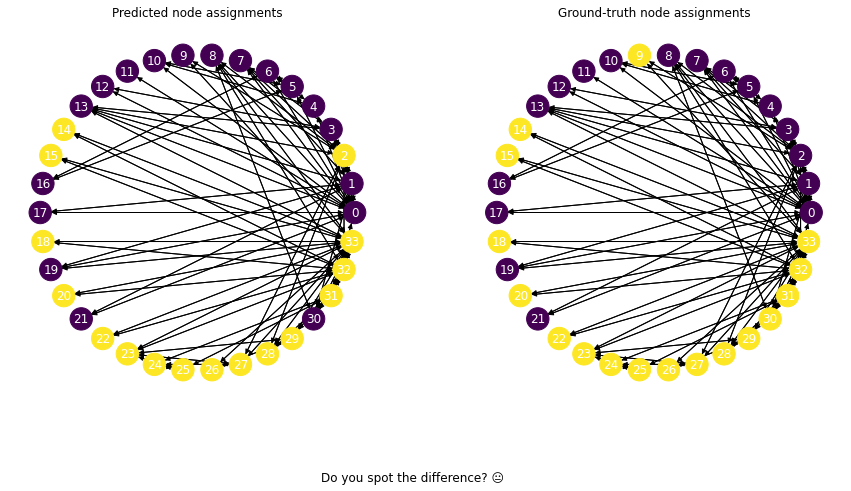

In [44]:
X = zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(X)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax_1 = fig.add_subplot(121)

nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white'
    )

ax_1.title.set_text('Predicted node assignments')

gt_labels = zacharys_karate_club_ground_truth()
ax_2 = fig.add_subplot(122)

nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white'
    )

ax_2.title.set_text('Ground-truth node assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

## Graph Attention (GAT) Layer

While the GCN we covered in the previous section can learn meaningful representations, it also has some shortcomings. Can you think of any?

In the GCN layer, the messages from all its neighbours and the node itself are equally weighted. This may lead to loss of node-specific information. E.g., consider the case when a set of nodes shares the same set of neighbors, and start out with different node features. Then because of averaging, their resulting output features would be the same. Adding self-edges mitigates this issue by a small amount, but this problem is magnified with increasing number of GCN layers and number of edges connecting to a node.

The graph attention (GAT) mechanism, as proposed by [Velickovic et al. (2017)](https://arxiv.org/abs/1710.10903), allows the network to learn how to weigh / assign importance to the node features from the neighbourhood when computing the new node features. This is very similar to the idea of using attention in Transformers, which were introduced in [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762).

(One could even argue that Transformers are graph attention networks operating on the special case of fully-connected graphs.)

In the figure below, $\vec{h}$ are the node features and $\vec{\alpha}$ are the learned attention weights.



<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/gat1.png" width="700px">

Figure Credit: [Velickovic et al. (2017)](https://arxiv.org/abs/1710.10903).<br>
(Detail: This image is showing multi-headed attention with 3 heads, each color corresponding to a different head. At the end, an aggregation function is applied over all the heads.)

To obtain the output node features of the GAT layer, we compute:

$$ \vec{h}'_i = \sum _{j \in \mathcal{N}(i)}\alpha_{ij} \mathbf{W} \vec{h}_j$$
Here, $\mathbf{W}$ is a weight matrix which performs a linear transformation on the input.





How do we obtain $\alpha$, or in other words, learn what to pay attention to?

Intuitively, the attention coefficient $\alpha_{ij}$ should rely on both the transformed features from nodes $i$ and $j$. So let's first define an attention mechanism function $\mathrm{attention\_fn}$ that computes the intermediary attention coefficients $e_{ij}$:
$$ e_{ij} = \mathrm{attention\_fn}(\mathbf{W}\vec{h}_i, \mathbf{W}\vec{h}_j)$$

To obtain normalized attention weights $\alpha$, we apply a softmax:
$$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum _{j \in \mathcal{N}(i)}\exp(e_{ij})}$$

For the function $a$, the authors of the GAT paper chose to concatenate the transformed node features (denoted by $||$) and apply a single-layer feedforward network, parameterized by a weight vector $\vec{\mathbf{a}}$ and with LeakyRelu as non-linearity.

In the implementation below, we refer to $\mathbf{W}$ as `attention_query_fn` and $\mathrm{attention\_fn}$ as `attention_logit_fn`.

$$\mathrm{attention\_fn}(\mathbf{W}\vec{h}_i, \mathbf{W}\vec{h}_j) =  \text{LeakyReLU}(\vec{\mathbf{a}}(\mathbf{W}\vec{h}_i || \mathbf{W}\vec{h}_j))$$

The figure below summarizes this attention mechanism visually.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/gat2.png" width="700px">

Figure Credit: [Velickovic et al. (2017)](https://arxiv.org/abs/1710.10903).
<!-- $\sum_{j \in \mathcal{N}(i)}\vec{\alpha}_{ij} \stackrel{!}{=}
1 $  -->



In [48]:
class GraphAttention():
    '''Graph Attention layer passing as described in
    https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
    jnp.array, may use edge features for computing attention weights, and
    ignore global features. It does not support nests.
    '''
    def __init__(
        self,
        attention_query_fn: Callable,
        attention_logit_fn: Callable,
        update_node_fn: Optional[Callable] = None,
        add_self_edges: bool = True
            ):
        '''Inits a GAT layer.

        Args:
            attention_query_fn: function to generates attention queries
            attention_logit_fn: function to convert attention queries to logits
            update_node_fn: function used to update the nodes, if None, will
                apply leaky ReLU and concatenate (if using multi-head attention)
            add_self_edges: whether to add self-edges to nodes
        '''
        self.attention_query_fn = attention_query_fn
        self.attention_logit_fn = attention_logit_fn

        if update_node_fn:
            self.update_node_fn = update_node_fn
        else:
            self.update_node_fn = lambda x: jnp.reshape(
                jax.nn.leaky_relu(x), (x.shape[0], -1)
                )

        self.add_self_edges = add_self_edges

    def __call__(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        '''Applies a Graph Attention layer.

        Passes nodes through the attention query function to transform
        node features.

        If `self.add_self_edges` is True, then self-edges are added to 
        senders and receivers so that each node includes itself in aggregation.

        Computes the softmax logits using a function that takes the
        embedded sender and receiver attributes,
        computes the attention softmax weights on the entire tree,
        applies attention weights, aggregates messages to nodes
        and applies the update function to the aggregated messages.

        Args:
            graph: a jraph.GraphsTuple

        Returns:
            Modified jraph.GraphsTuple.

        Raises:
            ValueError: If no node features are provided.
        '''
        nodes, _, receivers, senders, _, _, _ = graph

        if not nodes.shape:
            raise ValueError('GAT requires node features')

        nodes = self.attention_query_fn(nodes)
        total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]

        if self.add_self_edges:
            receivers, senders = add_self_edges_fn(
                receivers, senders, total_num_nodes
                )

        sent_attributes = nodes[senders]
        received_attributes = nodes[receivers]

        att_softmax_logits = self.attention_logit_fn(
            sent_attributes, received_attributes
            )

        att_weights = jraph.segment_softmax(
            att_softmax_logits, segment_ids=receivers,
            num_segments=nodes.shape[0]
            )

        messages = sent_attributes * att_weights

        nodes = jax.ops.segment_sum(
            messages, receivers, num_segments=nodes.shape[0]
            )

        return graph._replace(nodes=self.update_node_fn(nodes))

#### Test GAT Layer

In [49]:
def attention_logit_fn(
     sent_attributes: jnp.ndarray, received_attributes: jnp.ndarray,
        ) -> jnp.ndarray:
    '''Computes the intermediary attention coefficients.

    Args:
        sent_attributes: a jnp.ndarray containing sender nodes' attributes
        received_attributes: a jnp.ndarray containing receiver nodes' attributes
    '''
    x = jnp.concatenate((sent_attributes, received_attributes), axis=1)
    return hk.Linear(1)(x)

In [50]:
gat_layer = GraphAttention(
    attention_query_fn=lambda n: hk.Linear(8)(n),
    attention_logit_fn=attention_logit_fn,
)

In [51]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gat_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-2.1254564e-02,  2.4042883e+00, -4.0143323e-03,
              -2.0577878e-02,  1.8933861e+00,  1.1548430e+00,
              -5.3817675e-02, -1.0350263e-02],
             [-6.7768167e-03,  7.6658463e-01, -1.2799320e-03,
              -6.5610623e-03,  6.0368830e-01,  3.6821079e-01,
              -1.7159257e-02, -3.3000836e-03],
             [-2.1208903e-02,  2.3991234e+00, -4.0057087e-03,
              -2.0533672e-02,  1.8893188e+00,  1.1523622e+00,
              -5.3702068e-02, -1.0328028e-02],
             [-1.7733721e-02,  2.0060153e+00, -3.3493536e-03,
              -1.7169129e-02,  1.5797446e+00,  9.6354198e-01,
              -4.4902720e-02, -8.6357296e-03]], dtype=float32)

### Train GAT Model on Karate Club Dataset
We will now repeat the karate club experiment with a GAT network.

In [52]:
def gat_karate(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''A two-layer GAT for the karate club task.

    Args:
        graph: GraphsTuple the network processes.

    Returns:
        Output graph with updated node values.
    '''
    layer_1 = GraphAttention(
        attention_query_fn=lambda n: hk.Linear(8)(n),
        attention_logit_fn=attention_logit_fn
        )

    layer_2 = GraphAttention(
        attention_query_fn=lambda n: hk.Linear(8)(n),
        attention_logit_fn=attention_logit_fn,
        update_node_fn=hk.Linear(2)
        )

    graph = layer_1(graph)
    graph = layer_2(graph)
    return graph

Let's train the model!

We expect the model to reach an accuracy of about 0.97.

In [53]:
network = hk.without_apply_rng(hk.transform(gat_karate))

In [54]:
result = train(network, epochs=15)

Training...:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0	Accuracy: 0.50
Epoch: 1	Accuracy: 0.94
Epoch: 2	Accuracy: 0.94
Epoch: 3	Accuracy: 0.94
Epoch: 4	Accuracy: 0.97
Epoch: 5	Accuracy: 0.97
Epoch: 6	Accuracy: 0.97
Epoch: 7	Accuracy: 0.97
Epoch: 8	Accuracy: 0.97
Epoch: 9	Accuracy: 0.97
Epoch: 10	Accuracy: 1.00
Epoch: 11	Accuracy: 1.00
Epoch: 12	Accuracy: 1.00
Epoch: 13	Accuracy: 0.97
Epoch: 14	Accuracy: 0.97


The final node assignment predicted by the trained model:

In [55]:
result

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
             1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

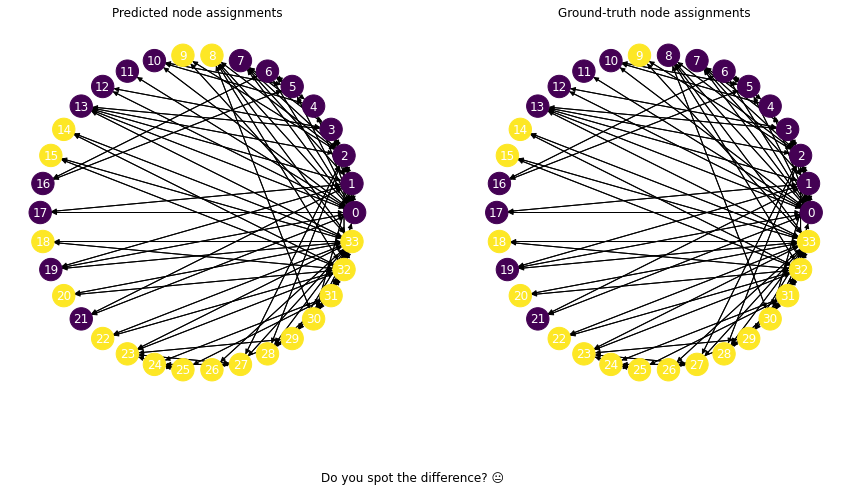

In [56]:
X = zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(X)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax_1 = fig.add_subplot(121)

nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white'
    )

ax_1.title.set_text('Predicted node assignments')

gt_labels = zacharys_karate_club_ground_truth()
ax_2 = fig.add_subplot(122)

nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white'
    )

ax_2.title.set_text('Ground-truth node assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

## Graph Classification on MUTAG (Molecules)

In the previous section, we used our GCN and GAT networks on a node classification problem. Now, let's use the same model architectures on a **graph classification task**.

The main difference from our previous setup is that instead of observing individual node latents, we are now attempting to summarize them into one embedding vector, representative of the entire graph, which we then use to predict the class of this graph.

We will do this on one of the most common tasks of this type -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

We will use the **MUTAG** dataset for this example, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection.

We have converted this dataset to be compatible with jraph and will download it in the cell below.

Citation for TUDatasets: [Morris, Christopher, et al. Tudataset: A collection of benchmark datasets for learning with graphs. arXiv preprint arXiv:2007.08663. 2020.](https://chrsmrrs.github.io/datasets/)


In [57]:
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle

--2022-06-24 05:52:59--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/mutag.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352981 (345K) [application/octet-stream]
Saving to: ‘/tmp/mutag.pickle’

mutag.pickle        100%[===================>] 344.71K  --.-KB/s    in 0.009s  

2022-06-24 05:53:00 (36.9 MB/s) - ‘/tmp/mutag.pickle’ saved [352981/352981]



In [58]:
with open('/tmp/mutag.pickle', 'rb') as f:
    mutag = pickle.load(f)

The dataset is saved as a list of examples, each example is a dictionary containing an input_graph and its corresponding target.

In [60]:
len(mutag)

188

In [61]:
# Inspect the first graph
g = mutag[0]['input_graph']
print(f'Number of nodes: {g.n_node[0]}')
print(f'Number of edges: {g.n_edge[0]}')
print(f'Node features shape: {g.nodes.shape}')
print(f'Edge features shape: {g.edges.shape}')

Number of nodes: 17
Number of edges: 38
Node features shape: (17, 7)
Edge features shape: (38, 4)


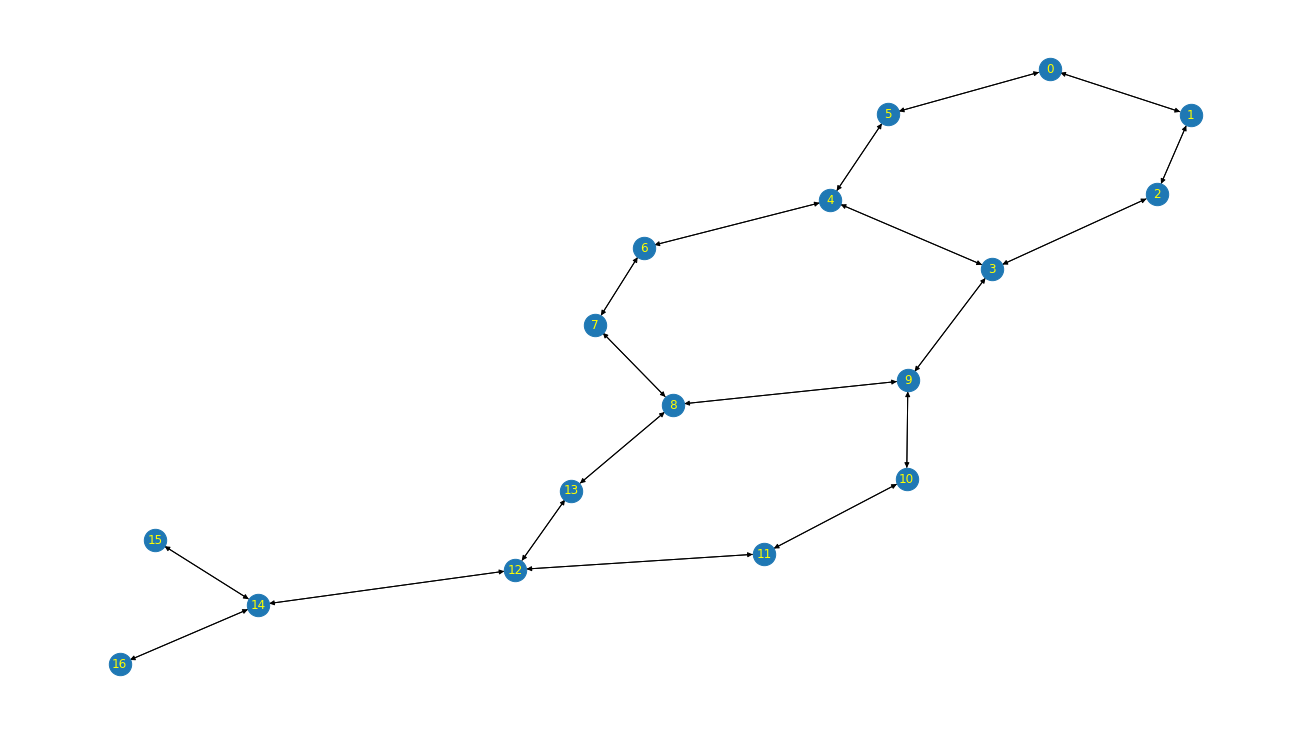

In [62]:
draw_jraph_graph_structure(g)

In [63]:
# Target for first graph
print(f"Target: {mutag[0]['target']}")

Target: [1]


We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the data into train and test subset in the proportion 3:1.

In [67]:
mutag_train, mutag_test = train_test_split(mutag, random_state=42)

#### Padding Graphs to Speed Up Training

Since jax recompiles the program for each graph size, training would take a long time due to recompilation for different graph sizes. To address that, we pad the number of nodes and edges in the graphs to nearest power of two. Since jax maintains a cache
of compiled programs, the compilation cost is amortized.

In [74]:
def next_power_of_2(x: int) -> int:
    '''An auxillary function that rounds a number up to the next power of 2.

    Args:
        x: an integer number

    Returns:
        An integer number – the nearest to x next power of 2.
    '''
    return pow(2, math.ceil(math.log(x) / math.log(2)))

In [75]:
def pad_graph(graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''Pads a batched `GraphsTuple` to the nearest power of two.
    For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs,
    this method would pad the `GraphsTuple` nodes and edges:

    7 nodes --> 8 nodes (2^3)
    5 edges --> 8 edges (2^3)

    And since padding is accomplished using `jraph.pad_with_graphs`,
    an extra graph and node is added:

    8 nodes --> 9 nodes
    3 graphs --> 4 graphs

    Args:
        graphs_tuple: a batched `GraphsTuple` (can be batch size 1)
    Returns:
        A graphs_tuple batched to the nearest power of two.
    '''
    return jraph.pad_with_graphs(
        graphs_tuple,
        next_power_of_2(jnp.sum(graphs_tuple.n_node)) + 1,
        next_power_of_2(jnp.sum(graphs_tuple.n_edge)),
        graphs_tuple.n_node.shape[0] + 1
        )

#### Graph Network Model Definition

We will use `jraph.GraphNetwork()` to build our graph model. The `GraphNetwork` architecture is defined in [Battaglia et al. (2018)](https://arxiv.org/pdf/1806.01261.pdf).

We first define update functions for nodes, edges, and the full graph (global). We will use MLP blocks for all three.

In [76]:
@jraph.concatenated_args
def update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    '''Node/edge update function for graph net.

    Args:
        feats: a jnp.ndarray of edge/node features

    Returns:
        A jnp.ndarray of updated nodes/edges.
    '''
    net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(128)])
    return net(feats)

In [77]:
@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
    '''Global update function for graph net.

    Args:
        feats: a jnp.ndarray of graph features

    Returns:
        Updated graph.
    '''
    net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(2)])
    return net(feats)

In [78]:
def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''A graph neural network model function.

    Args:
        graph: a jraph.GraphsTuple

    Returns:
        Graph, updated after one epoch of training.
    '''
    graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

    embedder = jraph.GraphMapFeatures(
        hk.Linear(128), hk.Linear(128), hk.Linear(128)
        )

    net = jraph.GraphNetwork(
        update_node_fn=update_fn,
        update_edge_fn=update_fn,
        update_global_fn=update_global_fn
        )

    return net(embedder(graph))

#### Loss and Accuracy Function
Define the classification cross-entropy loss and accuracy function.

In [79]:
def compute_loss(
    params: hk.Params, X: jraph.GraphsTuple, y: jnp.ndarray,
    net: jraph.GraphsTuple
        ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    '''Computes cross-entropy loss and accuracy for the model predictions.

    Args:
        params: model parameters
        X: a jraph.GraphsTuple
        y: a target jnp.ndarray
        net: a graph neural network

    Returns:
        A tuple of two jnp.ndarrays, each containing a single value –
        the cross-entropy loss and the mean accuracy of model predictions.
    '''
    pred_graph = net.apply(params, X)
    preds = jax.nn.log_softmax(pred_graph.globals)

    mask = jraph.get_graph_padding_mask(pred_graph)

    loss = -jnp.mean(preds * jax.nn.one_hot(y, 2) * mask[:, None])

    accuracy = jnp.sum(
        (jnp.argmax(pred_graph.globals, axis=1) == y) * mask
        ) / jnp.sum(mask)

    return loss, accuracy

#### Training and Evaluation Functions

In [80]:
def train(df: List[Dict[str, Any]], epochs: int) -> hk.Params:
    '''The main training loop. First, it transforms impure `net_fn`
    to pure functions with hk.transform. Then, it gets a candidate graph
    to initialize the network, initializes the network and the optimizer.
    After this, the training is started. At each training epoch,
    each batch of graphs is padded to the nearest next power of 2.

    Args:
        df: a subset of MUTAG dataset
        epochs: number of training epochs

    Returns:
        Parameters of a trained model.
    '''
    net = hk.without_apply_rng(hk.transform(net_fn))

    X = df[0]['input_graph']

    params = net.init(jax.random.PRNGKey(42), X)

    opt_init, opt_update = optax.adam(1e-4)
    opt_state = opt_init(params)

    compute_loss_fn = functools.partial(compute_loss, net=net)

    compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

    for epoch in trange(epochs, desc='Training...'):
        X = df[epoch % len(df)]['input_graph']
        y = df[epoch % len(df)]['target']

        X = pad_graph(X)

        y = jnp.concatenate([y, jnp.array([0])])

        (loss, acc), grad = compute_loss_fn(params, X, y)
        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)

        if epoch % 50 == 0:
            print(f'Epoch: {epoch}\tLoss: {loss:.4f}\tAccuracy: {acc:.4f}')

    return params

In [81]:
def evaluate(
    df: List[Dict[str, Any]], params: hk.Params
        ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    '''Evaluates the model. First, it transforms impure `net_fn`
    to pure functions with hk.transform. Then, it gets a candidate graph
    to initialize the network, initializes the network and the optimizer.
    After this, evaluation is started. During the evaluation,
    each batch of graphs is padded to the nearest next power of 2.

    Args:
        df: a subset of MUTAG dataset
        params: model parameters

    Returns:
        A tuple of two jnp.ndarrays, each containing a single value –
        the cross-entropy loss and the mean accuracy of model predictions.
    '''
    net = hk.without_apply_rng(hk.transform(net_fn))

    X = df[0]['input_graph']
    loss = 0.0
    accuracy = 0.0
    compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))

    for i in trange(len(df), desc='Evaluating...'):
        X = df[i]['input_graph']
        y = df[i]['target']
        X = pad_graph(X)
        y = jnp.concatenate([y, jnp.array([0])])
        curr_loss, curr_accuracy = compute_loss_fn(params, X, y)
        loss += curr_loss
        accuracy += curr_accuracy
        if i % 100 == 0:
            print(f'Evaluated {i + 1} graphs')

    loss /= len(df)
    accuracy /= len(df)
    print(f'Eval loss: {loss:.4f}, accuracy {accuracy:.4f}')
    return loss, accuracy

In [82]:
params = train(mutag_train, epochs=500)

Training...:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0	Loss: 0.4574	Accuracy: 0.0000
Epoch: 50	Loss: 0.4903	Accuracy: 0.0000
Epoch: 100	Loss: 0.0284	Accuracy: 1.0000
Epoch: 150	Loss: 0.6563	Accuracy: 0.0000
Epoch: 200	Loss: 0.0064	Accuracy: 1.0000
Epoch: 250	Loss: 0.0883	Accuracy: 1.0000
Epoch: 300	Loss: 0.0698	Accuracy: 1.0000
Epoch: 350	Loss: 0.1949	Accuracy: 0.0000
Epoch: 400	Loss: 0.1812	Accuracy: 0.0000
Epoch: 450	Loss: 0.0294	Accuracy: 1.0000


In [83]:
evaluate(mutag_test, params)

Evaluating...:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluated 1 graphs
Eval loss: 0.1472, accuracy 0.7872


(DeviceArray(0.14723885, dtype=float32),
 DeviceArray(0.78723407, dtype=float32))

We converge at ~79% test accuracy. We could of course further tune the parameters to improve this result.

## Link prediction on CORA (Citation Network)

The final problem type we will explore is **link prediction**, an instance of an **edge-level** task. Given a graph, our goal is to predict whether a certain edge $(u,v)$ should be present or not. This is often useful in the recommender system settings (e.g., propose new friends in a social network, propose a movie to a user).

As before, the first step is to obtain node latents $h_i$ using a GNN. In this context we will use the autoencoder language and call this GNN **encoder**. Then, we learn a binary classifier $f: (h_i, h_j) \to z_{i,j}$ (**decoder**), predicting if an edge $(i,j)$ should exist or not. While we could use a more elaborate decoder (e.g., an MLP), a common approach we will also use here is to focus on obtaining good node embeddings, and for the decoder simply use the similarity between node latents, i.e. $z_{i,j} = h_i^T h_j$.


For this problem we will use the [**Cora** dataset](https://linqs.github.io/linqs-website/datasets/#cora), a citation graph containing 2708 scientific publications. For each publication we have a 1433-dimensional feature vector, which is a bag-of-words representation (with a small, fixed dictionary) of the paper text. The edges in this graph represent citations, and are commonly treated as undirected. Each paper is in one of seven topics (classes) so you can also use this dataset for node classification.

Similar to MUTAG, we have converted this dataset to jraph for you.

Citation for the use of the Cora dataset:
- [Qing Lu and Lise Getoor. Link-Based Classification. International Conference on Machine Learning. 2003.](https://linqs.github.io/linqs-website/publications/#id:lu-icml03)
- [Sen, Prithviraj, et al. Collective classification in network data. AI magazine 29.3. 2008.](https://linqs.github.io/linqs-website/datasets/#cora)
- [Dataset download link](https://linqs.github.io/linqs-website/datasets/#cora)




In [84]:
!wget -P /tmp/ https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle

--2022-06-24 07:32:44--  https://storage.googleapis.com/dm-educational/assets/graph-nets/jraph_datasets/cora.pickle
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15618018 (15M) [application/octet-stream]
Saving to: ‘/tmp/cora.pickle’

cora.pickle         100%[===================>]  14.89M  --.-KB/s    in 0.1s    

2022-06-24 07:32:44 (126 MB/s) - ‘/tmp/cora.pickle’ saved [15618018/15618018]



In [85]:
with open('/tmp/cora.pickle', 'rb') as f:
    cora = pickle.load(f)

#### Splitting Edges and Adding "Negative" Edges
For the link prediction task, we split the edges into train, val and test sets and also add "negative" examples (edges that do not correspond to a citation). We will ignore the topic classes.

For the validation and test splits, we add the same number of existing edges ("positive examples") and non-existing edges ("negative examples").

In contrast to the validation and test splits, the training split only contains positive examples (set $T_+$). The $|T_+|$ negative examples to be used during training will be sampled ad hoc in each epoch and uniformly at random from all edges that are not in $T_+$. This allows the model to see a wider range of negative examples.

In [97]:
def split_edges(
    graph: jraph.GraphsTuple,
    val_size: Union[int, float] = 0.05,
    test_size: Union[int, float] = 0.1
        ) -> Tuple[jraph.GraphsTuple, jnp.ndarray, jnp.ndarray, jnp.ndarray,
                   jnp.ndarray, jnp.ndarray, jnp.ndarray,
                   jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    '''Split graph edges into train, validation and test sets.
    For validation and test sets, also include negative edges.
    Based on torch_geometric.utils.train_test_split_edges.

    Args:
        graph: a jraph.GraphsTuple
        val_size: either the proportion or an absolute number of val samples
        test_size: either the proportion or an absolute number of test samples

    Returns:
        The train graph (as jraph.GraphsTuple, edges are undirected),
        negative adjacency mask (as jnp.ndarray),
        and 8 jnp.ndarrays – positive/negative senders and receivers arrays
        for validation and test sets.
    '''
    mask = graph.senders < graph.receivers
    senders = graph.senders[mask]
    receivers = graph.receivers[mask]

    if graph.edges:
        train_s, test_s, train_r, test_r, train_e, test_e = train_test_split(
            senders, receivers, graph.edges, test_size=test_size,
            random_state=42
            )
        train_s, val_s, train_r, val_r, train_e, val_e = train_test_split(
            senders, receivers, graph.edges, test_size=val_size,
            random_state=42
            )
    else:
        train_s, test_s, train_r, test_r = train_test_split(
            senders, receivers, test_size=test_size,
            random_state=42
            )
        train_s, val_s, train_r, val_r = train_test_split(
            senders, receivers, test_size=val_size,
            random_state=42
            )
        train_e = None
        test_e = None
        val_e = None

    train_s_undir = jnp.concatenate((train_s, train_r))
    train_r_undir = jnp.concatenate((train_r, train_s))
    train_s = train_s_undir
    train_r = train_r_undir

    neg_adj_mask = np.ones((graph.n_node[0], graph.n_node[0]), dtype=np.uint8)

    neg_adj_mask = np.triu(neg_adj_mask, k=1)
    neg_adj_mask[graph.senders, graph.receivers] = 0
    neg_adj_mask = neg_adj_mask.astype(np.bool)
    neg_senders, neg_receivers = neg_adj_mask.nonzero()

    _, test_neg_s, _, test_neg_r = train_test_split(
        neg_senders, neg_receivers, test_size=test_s.shape[0], random_state=42
        )

    _, val_neg_s, _, val_neg_r = train_test_split(
        neg_senders, neg_receivers, test_size=val_s.shape[0], random_state=42
        )

    train_graph = jraph.GraphsTuple(
        nodes=graph.nodes,
        edges=train_e,
        senders=train_s,
        receivers=train_r,
        n_node=graph.n_node,
        n_edge=jnp.array([len(train_s)]),
        globals=graph.globals
        )

    return (train_graph, neg_adj_mask,
        val_s, val_r, val_neg_s, val_neg_r,
        test_s, test_r, test_neg_s, test_neg_r)

#### Test the Edge Splitting Function

In [98]:
graph = cora[0]['input_graph']

In [99]:
train_graph, neg_adj_mask, val_s, val_r, val_neg_s, val_neg_r, test_s, test_r, test_neg_s, test_neg_r = split_edges(graph)

In [100]:
print(f'Train set: {train_graph.senders.shape[0]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {val_s.shape[0]} positive edges, {val_neg_s.shape[0]} negative edges')
print(f'Test set: {test_s.shape[0]} positive edges, {test_neg_s.shape[0]} negative edges')
print(f'Negative adjacency mask shape: {neg_adj_mask.shape}')
print(f'Numbe of negative edges to sample from: {neg_adj_mask.sum()}')

Train set: 10028 positive edges, we will sample the same number of negative edges at runtime
Val set: 264 positive edges, 264 negative edges
Test set: 528 positive edges, 528 negative edges
Negative adjacency mask shape: (2708, 2708)
Numbe of negative edges to sample from: 3660000



*Note*: It will often happen during training that as a negative example, we sample an initially existing edge (that is now e.g. a positive example in the test set). We are however not allowed to check for this, as we should be unaware of the existence of test edges during training.

Assuming our dot product decoder, we are essentially attempting to bring the latents of endpoints of edges from $T_+$ closer together, and make the latents of all other pairs of nodes as distant as possible. As this is impossible to fully satisfy, the hope is that the model will "fail" to distance those pairs of nodes where the edges should actually exist (positive examples from the test set).

#### Graph Network Model Definition

We will use jraph.GraphNetwork to build our graph net model.

We first define update functions for node features. We are not using edge or global features for this task.

In [101]:
@jraph.concatenated_args
def update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    '''Node update function for graph net.

    Args:
        feats: a jnp.ndarray of node features

    Returns:
        A jnp.ndarray of updated nodes/.
    '''
    net = hk.Sequential([hk.Linear(128), jax.nn.relu, hk.Linear(64)])
    return net(feats)

In [102]:
def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    '''A graph neural network model function.

    Args:
        graph: a jraph.GraphsTuple

    Returns:
        Graph, updated after one epoch of training.
    '''
    graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

    net = jraph.GraphNetwork(
        update_node_fn=update_fn, update_edge_fn=None, update_global_fn=None
        )

    return net(graph)

In [103]:
def decode(
    pred_graph: jraph.GraphsTuple, senders: jnp.ndarray, receivers: jnp.ndarray
        ) -> jnp.ndarray:
    '''Given a set of candidate edges, take dot product of respective nodes.

    Args:
        pred_graph: input graph
        senders: senders of candidate edges
        receivers: receivers of candidate edges

    Returns:
        For each edge, computes dot product of the features of the two nodes.
    '''
    return jnp.squeeze(
        jnp.sum(pred_graph.nodes[senders] * pred_graph.nodes[receivers], axis=1)
        )

To evaluate our model, we first apply the sigmoid function to obtained dot products to get a score $s_{i,j} \in [0,1]$ for each edge. Now, we can pick a threshold $\tau$ and say that we predict all pairs $(i,j)$ s.t. $s_{i,j} \geq \tau$ as edges (and all the rest as non-edges).

#### Loss and ROC-AUC-Metric Function
Define the binary classification cross-entropy loss.
To aggregate the results over all choices of $\tau$, we will use ROC-AUC (the area under the ROC curve) as our evaluation metric.

In [112]:
def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    '''Computes binary cross-entropy with logits loss.
    Combines sigmoid and BCE, uses log-sum-exp trick for numerical stability.
    See https://stackoverflow.com/a/66909858 if you want to learn more.

    Args:
        x: predictions (logits)
        y: labels

    Returns:
        Binary cross-entropy loss with mean aggregation.
    '''
    max_val = jnp.clip(x, 0, None)

    loss = x - x * y + max_val + jnp.log(
        jnp.exp(-max_val) + jnp.exp((-x - max_val))
        )
    return loss.mean()

In [113]:
def compute_loss(
    params: hk.Params, graph: jraph.GraphsTuple,
    senders: jnp.ndarray, receivers: jnp.ndarray,
    labels: jnp.ndarray, net: hk.Transformed
        ) -> Tuple[jnp.ndarray, jnp.ndarray]:
    '''Computes loss.

    Args:
        params: model parameters:
        graph: a jraph.GraphsTuple
        senders: a jnp.ndarray of sender nodes
        receivers: a jnp.ndarray of receiver nodes
        labels: a jnp.ndarray of ground truth labels
        net: a graph neural network

    Returns:
        A tuple of two jnp.ndarrays –
        binary cross-entropy loss with mean aggregation, and model predictions.
    '''
    pred_graph = net.apply(params, graph)
    preds = decode(pred_graph, senders, receivers)
    loss = compute_bce_with_logits_loss(preds, labels)
    return loss, preds

In [114]:
def compute_roc_auc(preds: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
    '''Computes ROC-AUC (area under the curve) score for classification.

    Args:
        preds: a jnp.ndarray of model predictions
        labels: a jnp.ndarray of ground truth labels
    '''
    return roc_auc_score(labels, jax.nn.sigmoid(preds))

Helper function for sampling negative edges during training.

In [115]:
def negative_sampling(
    graph: jraph.GraphsTuple, n: int
        ) -> Tuple[jnp.DeviceArray, jnp.DeviceArray]:
    '''Samples negative edges, i.e. edges that don't exist in the input graph.

    Args:
        graph: a jraph.GraphsTuple
        n: number of negative samples

    Returns:
        A tuple of two jnp.DeviceArrays –
        sender and receiver node arrays for negative edges.
    '''
    pos_idx = graph.senders * graph.n_node[0] + graph.receivers

    alpha = jnp.abs(
        1 / (1 - 1.1 *(graph.senders.shape[0] / graph.n_node[0] ** 2))
        )

    perm = jax.random.randint(
        jax.random.PRNGKey(42),
        shape=(int(alpha * n),),
        minval=0,
        maxval=graph.n_node[0] ** 2,
        dtype=jnp.uint32)

    mask = jnp.isin(perm, pos_idx)

    perm = perm[~mask][:n]

    neg_senders = perm // graph.n_node[0]
    neg_receivers = perm % graph.n_node[0]

    return neg_senders, neg_receivers

Let's write the training loop:

In [118]:
def train(df: List[Dict[str, Any]], epochs: int) -> hk.Params:
    '''The main training loop. First, it transforms impure `net_fn`
    to pure functions with hk.transform. Then, it gets a candidate graph
    to initialize the network, prepares the validation and test data,
    initializes the network and the optimizer.
    After this, the training is started.

    Args:
        df: a subset of CORA dataset
        epochs: number of training epochs

    Returns:
        Parameters of a trained model.
    '''
    net = hk.without_apply_rng(hk.transform(net_fn))
    graph = df[0]['input_graph']

    train_graph, _, val_s, val_r, val_neg_s, val_neg_r, test_s, test_r, test_neg_s, test_neg_r = split_edges(graph)

    val_senders = jnp.concatenate((val_s, val_neg_s))
    val_receivers = jnp.concatenate((val_r, val_neg_r))

    val_labels = jnp.concatenate(
        (jnp.ones(len(val_s)), jnp.zeros(len(val_neg_s)))
        )

    test_senders = jnp.concatenate((test_s, test_neg_s))
    test_receivers = jnp.concatenate((test_r, test_neg_r))

    test_labels = jnp.concatenate(
        (jnp.ones(len(test_s)), jnp.zeros(len(test_neg_s)))
        )

    params = net.init(jax.random.PRNGKey(42), train_graph)

    opt_init, opt_update = optax.adam(1e-4)
    opt_state = opt_init(params)

    compute_loss_fn = functools.partial(compute_loss, net=net)

    compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

    for epoch in trange(epochs, desc='Training...'):
        print(f'Epoch: {epoch}')
        train_neg_senders, train_neg_receivers = negative_sampling(
            train_graph, train_graph.senders.shape[0]
            )
        train_senders = jnp.concatenate(
            (train_graph.senders, train_neg_senders)
            )
        train_receivers = jnp.concatenate(
            (train_graph.receivers, train_neg_receivers)
            )
        train_labels = jnp.concatenate(
            (jnp.ones(len(train_graph.senders)),
             jnp.zeros(len(train_neg_senders)))
            )

        (train_loss, train_preds), grad = compute_loss_fn(
            params, train_graph, train_senders, train_receivers, train_labels
            )

        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        if epoch % 10 == 0 or epoch == epochs - 1:
            train_roc_auc = compute_roc_auc(train_preds, train_labels)
            val_loss, val_preds = compute_loss(
                params, train_graph, val_senders, val_receivers, val_labels, net
                )
            val_roc_auc = compute_roc_auc(val_preds, val_labels)
            print(f'Train loss: {train_loss}\tTrain ROC-AUC: {train_roc_auc}')
            print(f'Val loss: {val_loss}\tVal ROC-AUC: {val_roc_auc}')
        test_loss, test_preds = compute_loss(
            params, train_graph, test_senders, test_receivers, test_labels, net
            )
        test_roc_auc = compute_roc_auc(test_preds, test_labels)
        print(f'Test loss: {test_loss}\tTest ROC-AUC: {test_roc_auc}\n')

    return params

Let's train the model! We expect the model to reach roughly test_roc_auc of 0.84.

(Note that ROC-AUC is a scalar between 0 and 1, with 1 being the ROC-AUC of a perfect classifier.)

In [119]:
params = train(cora, epochs=200)

Training...:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.6904109716415405	Train ROC-AUC: 0.5966249319380301
Val loss: 0.6905497312545776	Val ROC-AUC: 0.590736914600551
Test loss: 0.6903665661811829	Test ROC-AUC: 0.59400826446281

Epoch: 1
Test loss: 0.6900044083595276	Test ROC-AUC: 0.602369576446281

Epoch: 2
Test loss: 0.6896500587463379	Test ROC-AUC: 0.6109156192607897

Epoch: 3
Test loss: 0.6893017292022705	Test ROC-AUC: 0.6190850264003673

Epoch: 4
Test loss: 0.6889587044715881	Test ROC-AUC: 0.6272669880624426

Epoch: 5
Test loss: 0.6886191964149475	Test ROC-AUC: 0.6350759010560147

Epoch: 6
Test loss: 0.6882807612419128	Test ROC-AUC: 0.642493830348944

Epoch: 7
Test loss: 0.6879420876502991	Test ROC-AUC: 0.6495207759412306

Epoch: 8
Test loss: 0.6876012682914734	Test ROC-AUC: 0.6563002180899908

Epoch: 9
Test loss: 0.687258243560791	Test ROC-AUC: 0.6629828110651974

Epoch: 10
Train loss: 0.6857625246047974	Train ROC-AUC: 0.6985227320017019
Val loss: 0.6879827976226807	Val ROC-AUC: 0.6439178719008265
Test loss: 0.6

## [Bonus] Intro to Graph Adversarial Attacks

It is known that deep neural networks for vision can be easily fooled by **imperceptible** transformations of the input:

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_attack.png" width="600px">

Figure credit: https://openai.com/blog/adversarial-example-research/, adapted from [Goodfellow et al. (2015)](https://arxiv.org/pdf/1412.6572.pdf) (page 3).

 In this setting, we often define imperceptibility, i.e., the attacker budget, as some neighborhood of the input image. For example, assuming the input image $x$ has pixel values in $[0,1]$, we might look for adversarial attacks inside the $l_\infty$ ball of radius $0.1$, i.e., *adversarial inputs* $x'$ s.t. $||x-x'||_\infty < 0.1$ on which the network makes a mistake.

Unsuprisingly, this extends to various other domains (language, sound, etc.), as well as graphs -- tweaking the features of a node or adding/removing an edge can easily confuse a GNN model:

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/perturbed_graph.png" width="500px">

Figure credit:  https://github.com/DSE-MSU/DeepRobust (adversary_examples/graph_attack_example.png)

However, there are several challenges specific to graphs that make adversarial attacks and defenses interesting for GNNs:

1. **The graphs are discrete** -- as pixel values are continuous, perturbing them almost always leads to a valid input image. However, perturbing adjacency matrices is more involved as they need to remain discrete, which also makes gradient-based methods significantly harder to directly apply.

2. **The nodes in the graph are not independent** -- by the nature of GNNs, perturbing the features of one node might affect the prediction of another. This led to new notions such as *influencer attacks* where we attempt to make a GNN misclassify a node without directly manipulating it in any way.

3. **It is difficult to define imperceptibility** -- while in images this comes naturally and can be easily formalized by thinking about $l_\infty$ or $l_2$ neighborhoods, it is unclear how this generalizes to graphs. Various definitions have been proposed (e.g., the attack should preserve some graph properties such as the degree distribution), but also used to craft *graph purification* procedures.

These unique challenges lead to a very active research field: follow [this repo](https://github.com/safe-graph/graph-adversarial-learning-literature) for most recent papers. We also recommend [DeepRobust](https://github.com/DSE-MSU/DeepRobust), which offers implementations of various attack/defense papers.

### Summary
In this tutorial, we learned about how to represent directed and undirected graphs in jraph, how to create the basic GNN blocks (GCN + GAT) and how to compose them into GNNs. We also learned about three types of graph predictions tasks (node classification, link prediction and graph classification) and trained a model on each of these tasks.


To practice your knowledge, you can:
* Create your own graphs, e.g. following the toy graph template and adding nodes, edges, features.
* Modify the GNN blocks, e.g. by changing the `update_node_fn()` / `update_edge_fn()` functions.
* Train a model on a different dataset and/or task.